# RNA velocity and trajectory inference 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
#from matplotlib.pyplot import rc_context　　　　　　　　　　　　　　　
import scanpy as sc
import scvelo as scv
import cellrank as cr
from matplotlib import colors # for better color set
import os

import scvelo as scv
scv.set_figure_params()
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.9.7) on 2022-04-19 15:14.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


In [11]:
# Here are the tool version I am using. I noticed that anndata, and rpy2 may not work well depending on the version.
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, fontsize=11, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


### Import Seurat object
In order to keep the same preprocessed cells and preserve UMAP coordinates it is necessary to import Seurat object and convert to AnnData object to be able to run scanpy (and PAGA)

In [12]:
# Package to convert Seurat > SingleCellExperiment > AnnData
import anndata2ri

In [13]:
# Activate the anndata2ri conversion 
anndata2ri.activate()

In [14]:
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [15]:
%%R
library(Seurat)

In [16]:
%%R
# read seurat object [without hemocyte and unknown]
so <- readRDS('datasets/seurat/Seurat_aggr_QC2.rds')
#load("datasets/seurat/Seurat_aggr_QC2.RData")

In [17]:
%%R
# Confirming that is a Seurat object and numver of cells and features are same as previously
so

An object of class Seurat 
51496 features across 4184 samples within 4 assays 
Active assay: SCT (9607 features, 3000 variable features)
 3 other assays present: unspliced, ambiguous, spliced
 2 dimensional reductions calculated: pca, umap


In [18]:
%%R -o so_sce
# 1st step: convert the Seurat object to a SingleCellExperiment object
so_sce <- as.SingleCellExperiment(so)
#so_sce

In [19]:
#del adata
# Then opening the SingleCellExperiment object in this environment will automatically be recognize as AnnData
adata = so_sce
adata

AnnData object with n_obs × n_vars = 4184 × 9607
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'sample', 'percent.mt', 'percent.rb', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'SCT_snn_res.1', 'SCT_snn_res.1.6', 'seurat_clusters', 'clusters', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_22', 'DF.classifications_0.25_0.09_22', 'pANN_0.25_0.09_12', 'DF.classifications_0.25_0.09_12', 'predicted.id', 'prediction.score.EB1', 'prediction.score.ISC1', 'prediction.score.ISC2', 'prediction.score.EC.like', 'prediction.score.EB3', 'prediction.score.EB2', 'prediction.score.mEC', 'prediction.score.AstC.EE', 'prediction.score.apEC', 'prediction.score.Tk.EE', 'prediction.score.max', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [20]:
# This step convert to float64 so it will be more consistent among platforms
# this is not required and results will be comparable without it
adata.X = adata.X.astype('float64') 

In [21]:
# converting some columns to the right format
adata.obs["nFeature_spliced"] = adata.obs["nFeature_spliced"].astype(int)
adata.obs["nFeature_unspliced"] = adata.obs["nFeature_unspliced"].astype(int)
adata.obs["nFeature_ambiguous"] = adata.obs["nFeature_ambiguous"].astype(int)
adata.obs["nFeature_SCT"] = adata.obs["nFeature_SCT"].astype(int)

In [22]:
adata

AnnData object with n_obs × n_vars = 4184 × 9607
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'sample', 'percent.mt', 'percent.rb', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'SCT_snn_res.1', 'SCT_snn_res.1.6', 'seurat_clusters', 'clusters', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_22', 'DF.classifications_0.25_0.09_22', 'pANN_0.25_0.09_12', 'DF.classifications_0.25_0.09_12', 'predicted.id', 'prediction.score.EB1', 'prediction.score.ISC1', 'prediction.score.ISC2', 'prediction.score.EC.like', 'prediction.score.EB3', 'prediction.score.EB2', 'prediction.score.mEC', 'prediction.score.AstC.EE', 'prediction.score.apEC', 'prediction.score.Tk.EE', 'prediction.score.max', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [25]:
#del adata
adata2 = sc.read_loom("datasets/seurat/Seurat_aggr_QC2.loom", validate=False)
#adata = sc.read_loom("aggr/merged.loom")

In [26]:
# Import the loom file information and merge
ldata = scv.read("datasets/aggr/merged.loom", cache=True)
adata = scv.utils.merge(adata, ldata)

... reading from cache file cache/datasets-aggr-merged.h5ad


In [27]:
adata

AnnData object with n_obs × n_vars = 4184 × 9607
    obs: 'orig.ident', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'sample', 'percent.mt', 'percent.rb', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'SCT_snn_res.1', 'SCT_snn_res.1.6', 'seurat_clusters', 'clusters', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_22', 'DF.classifications_0.25_0.09_22', 'pANN_0.25_0.09_12', 'DF.classifications_0.25_0.09_12', 'predicted.id', 'prediction.score.EB1', 'prediction.score.ISC1', 'prediction.score.ISC2', 'prediction.score.EC.like', 'prediction.score.EB3', 'prediction.score.EB2', 'prediction.score.mEC', 'prediction.score.AstC.EE', 'prediction.score.apEC', 'prediction.score.Tk.EE', 'prediction.score.max', 'ident', 'sample_batch', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'St

In [28]:
# The preprocessing involves: 
# filtering cells that have minimum of 20 shared counts
# normalize per cell
# filter genes dispersion (top 2000 genes)
# log1p
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)# , n_pcs=20, n_neighbors=20)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


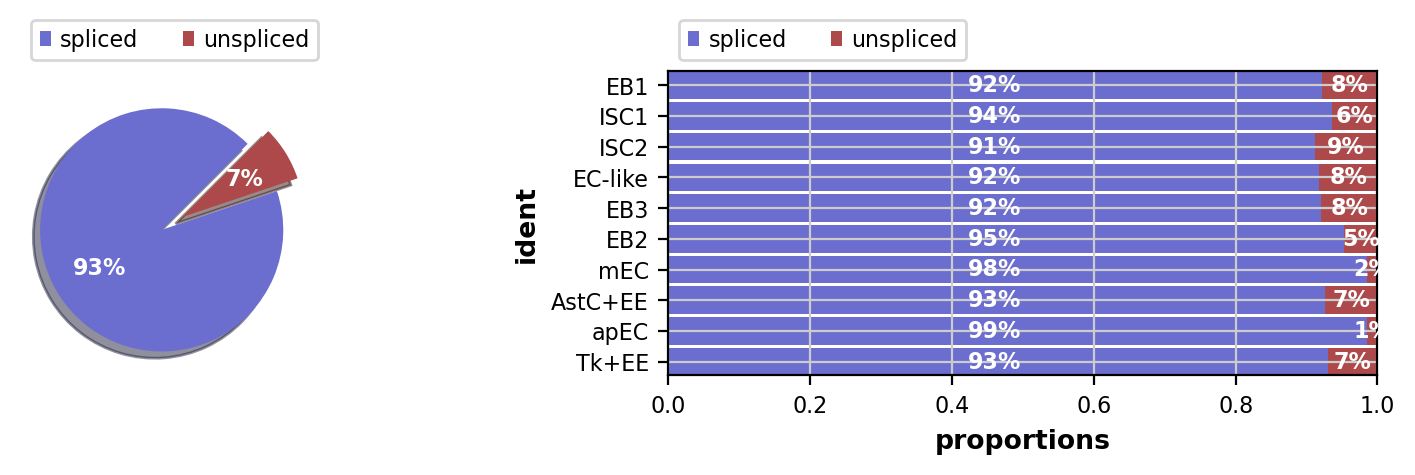

In [29]:
scv.pl.proportions(adata, groupby='ident')

# Running in the advanced dynamical model

In [30]:
scv.tl.recover_dynamics(adata, n_jobs=8) # necessary for the dynamical mode
scv.tl.velocity(adata, mode='dynamical') #deterministic, stochastic, steady_state

recovering dynamics (using 8/144 cores)


  0%|          | 0/2556 [00:00<?, ?gene/s]

    finished (0:03:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [31]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/144 cores)


  0%|          | 0/4184 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [32]:
adata.obs.ident

AACCATGGTAAGCAAT        EB1
AACCCAAAGCTATCTG       ISC1
AAAGGATTCTTGTGCC       ISC1
AACAAAGAGAATAGTC       ISC2
AACAAGACAGCTTCGG    EC-like
                     ...   
TTTGGTTGTACGGATG       ISC1
TTGGTTTAGGCATCAG        EB1
TTGGTTTAGACCATGG       ISC2
TTTCCTCTCGGTAGGA       ISC1
TTGTGTTCAGCGGTCT       ISC2
Name: ident, Length: 4184, dtype: category
Categories (10, object): ['EB1', 'ISC1', 'ISC2', 'EC-like', ..., 'mEC', 'AstC+EE', 'apEC', 'Tk+EE']

In [33]:
adata.obs

orig.ident  nCount_spliced  nFeature_spliced  \
AACCATGGTAAGCAAT  SeuratProject         42819.0              3477   
AACCCAAAGCTATCTG  SeuratProject         27407.0              3018   
AAAGGATTCTTGTGCC  SeuratProject         22334.0              2928   
AACAAAGAGAATAGTC  SeuratProject         14780.0              1958   
AACAAGACAGCTTCGG  SeuratProject         22777.0              2480   
...                         ...             ...               ...   
TTTGGTTGTACGGATG  SeuratProject         75180.0              4451   
TTGGTTTAGGCATCAG  SeuratProject         22748.0              2405   
TTGGTTTAGACCATGG  SeuratProject         11717.0              1617   
TTTCCTCTCGGTAGGA  SeuratProject         70083.0              4151   
TTGTGTTCAGCGGTCT  SeuratProject         48166.0              3397   

                  nCount_unspliced  nFeature_unspliced  nCount_ambiguous  \
AACCATGGTAAGCAAT            3926.0                 714            1101.0   
AACCCAAAGCTATCTG            2207.0                 517             657.0   
AAAGGATTCTTGTGCC            1371.0                 397             567.0   
AACAAAGAGAATAGTC            1265.0                 277             356.0   
AACAAGACAGCTTCGG            1275.0                 352             451.0   
...                            ...                 ...               ...   
TTTGGTTGTACGGATG            4484.0                 772            1434.0   
TTGGTTTAGGCATCAG            3086.0                 520             670.0   
TTGGTTTAGACCATGG            1809.0                 344             429.0   
TTTCCTCTCGGTAGGA            3401.0                 780            1640.0   
TTGTGTTCAGCGGTCT            4553.0                 812            1397.0   

                  nFeature_ambiguous sample  percent.mt  percent.rb  ...  \
AACCATGGTAAGCAAT                 318   1DAE    4.821462   53.670100  ...   
AACCCAAAGCTATCTG                 240   1DAE    1.833643   57.094903  ...   
AAAGGATTCTTGTGCC                 211   1DAE    1.027587   45.750873  ...   
AACAAAGAGAATAGTC                 148   1DAE    2.239615   59.397835  ...   
AACAAGACAGCTTCGG                 171   1DAE    2.767063   57.623919  ...   
...                              ...    ...         ...         ...  ...   
TTTGGTTGTACGGATG                 341   3DAE    2.585536   55.300612  ...   
TTGGTTTAGGCATCAG                 244   3DAE    3.781349   57.969931  ...   
TTGGTTTAGACCATGG                 164   3DAE    4.612653   58.880259  ...   
TTTCCTCTCGGTAGGA                 344   3DAE    2.169893   46.502005  ...   
TTGTGTTCAGCGGTCT                 361   3DAE    4.248415   59.228501  ...   

                    ident  sample_batch Clusters         _X         _Y  \
AACCATGGTAAGCAAT      EB1   1DAE_1DAE:x        3 -30.738956  -6.097093   
AACCCAAAGCTATCTG     ISC1   1DAE_1DAE:x        2 -30.671553   3.403684   
AAAGGATTCTTGTGCC     ISC1   1DAE_1DAE:x        1  22.289242  25.160275   
AACAAAGAGAATAGTC     ISC2   1DAE_1DAE:x        1  28.603315  29.788687   
AACAAGACAGCTTCGG  EC-like   1DAE_1DAE:x        2 -33.416283  -2.823817   
...                   ...           ...      ...        ...        ...   
TTTGGTTGTACGGATG     ISC1   3DAE_3DAE:x        2  12.363239  15.870676   
TTGGTTTAGGCATCAG      EB1   3DAE_3DAE:x        0   3.402410 -26.382795   
TTGGTTTAGACCATGG     ISC2   3DAE_3DAE:x        6 -25.613077 -23.086945   
TTTCCTCTCGGTAGGA     ISC1   3DAE_3DAE:x        1 -19.884691  -2.706260   
TTGTGTTCAGCGGTCT     ISC2   3DAE_3DAE:x        0 -19.123198 -28.278101   

                 initial_size_spliced initial_size_unspliced initial_size  \
AACCATGGTAAGCAAT                42819                   3926      42819.0   
AACCCAAAGCTATCTG                27407                   2207      27407.0   
AAAGGATTCTTGTGCC                22334                   1371      22334.0   
AACAAAGAGAATAGTC                14780                   1265      14780.0   
AACAAGACAGCTTCGG                22777                   1275      22777.0   
...            

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_UMAP_stream.pdf


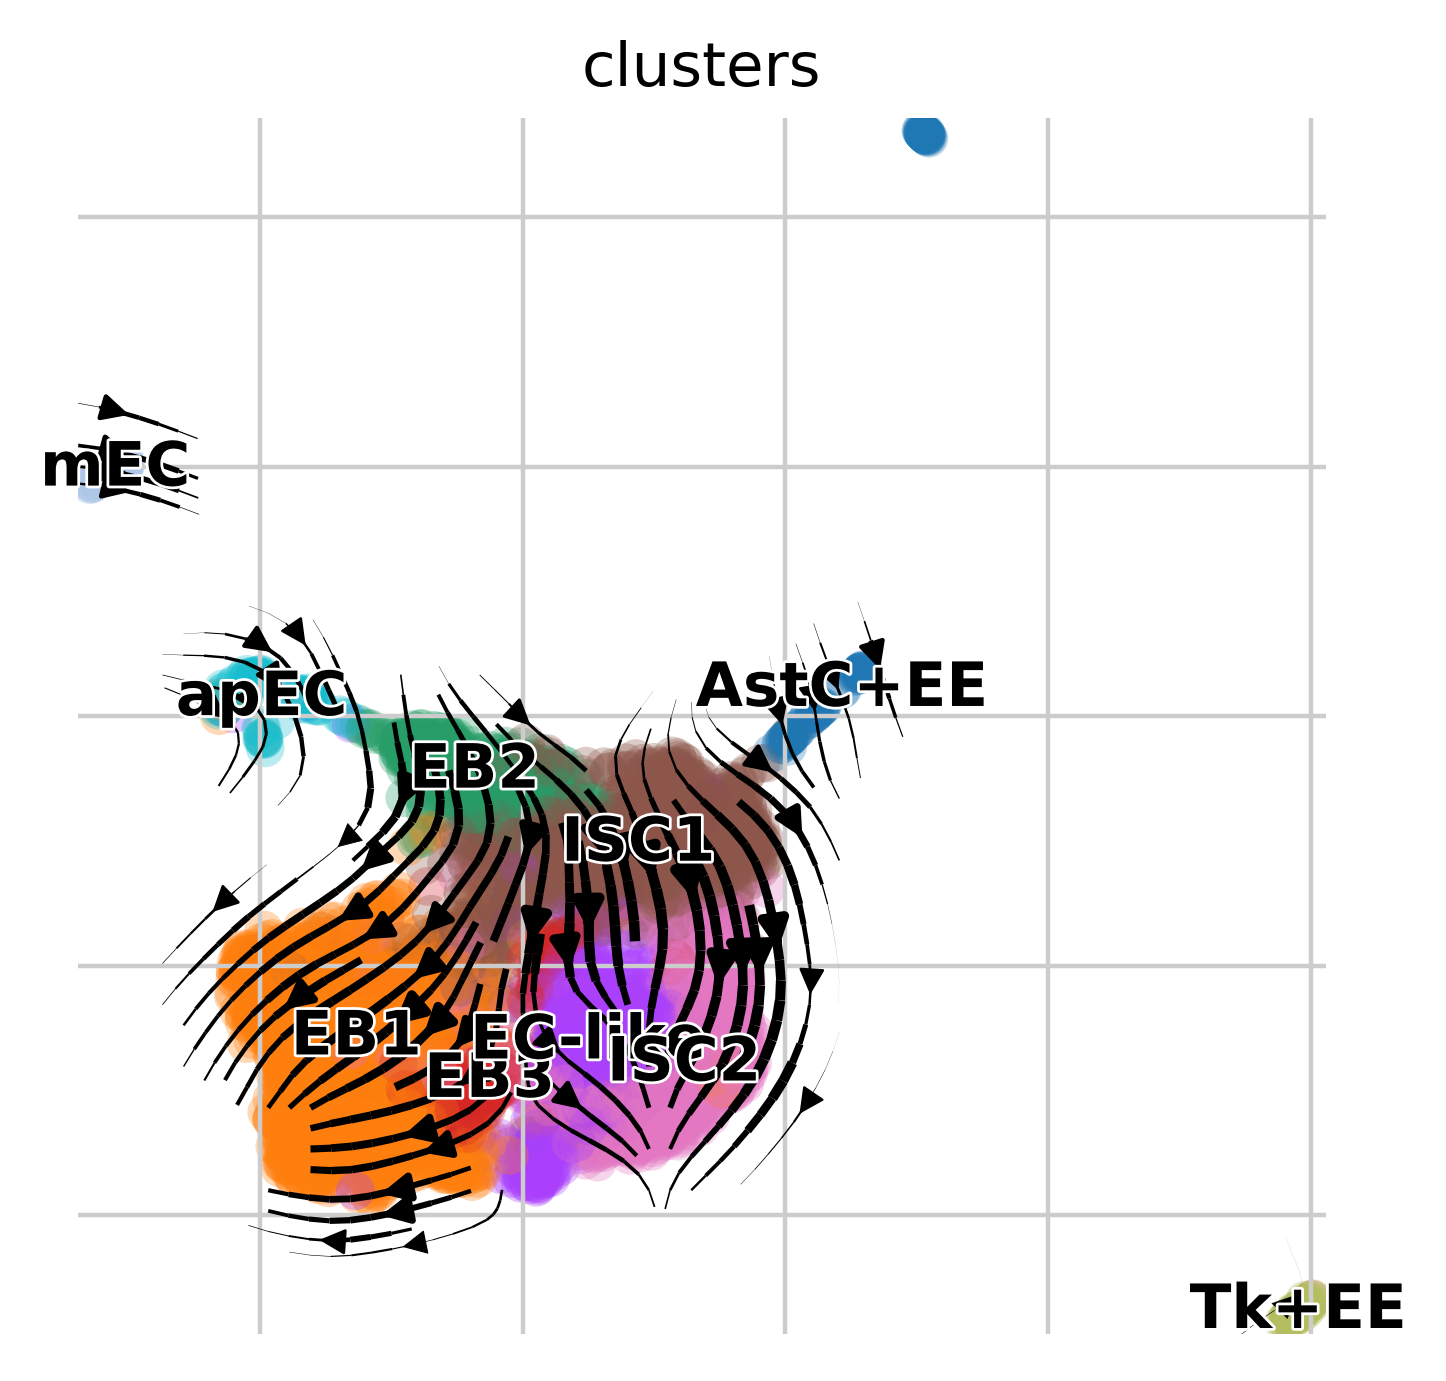

In [34]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', smooth=0.8, frameon = False, save = 'UMAP_stream.pdf')

saving figure to file ./figures/scvelo_UMAP_grid.pdf


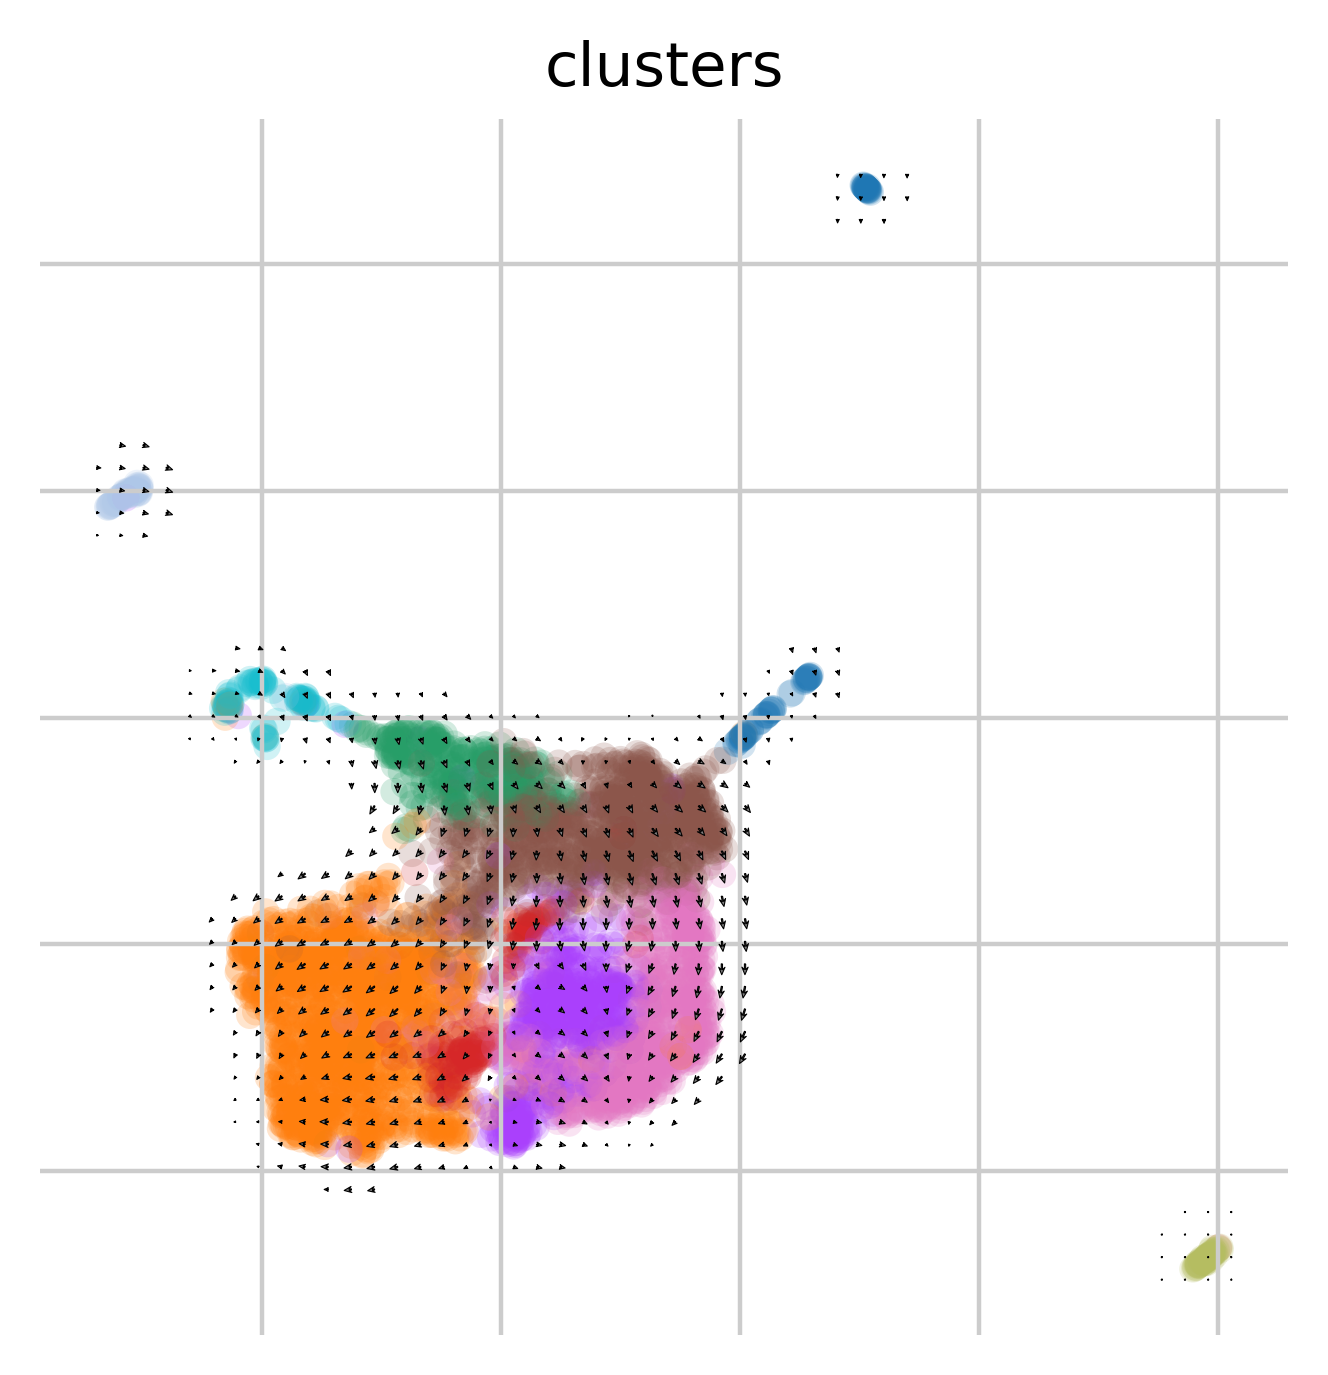

In [35]:
scv.pl.velocity_embedding_grid(adata, basis = 'umap', color='clusters', smooth=0.8,
                               frameon = False, save = 'UMAP_grid.pdf')

saving figure to file ./figures/scvelo_UMAP_stream_sample.pdf


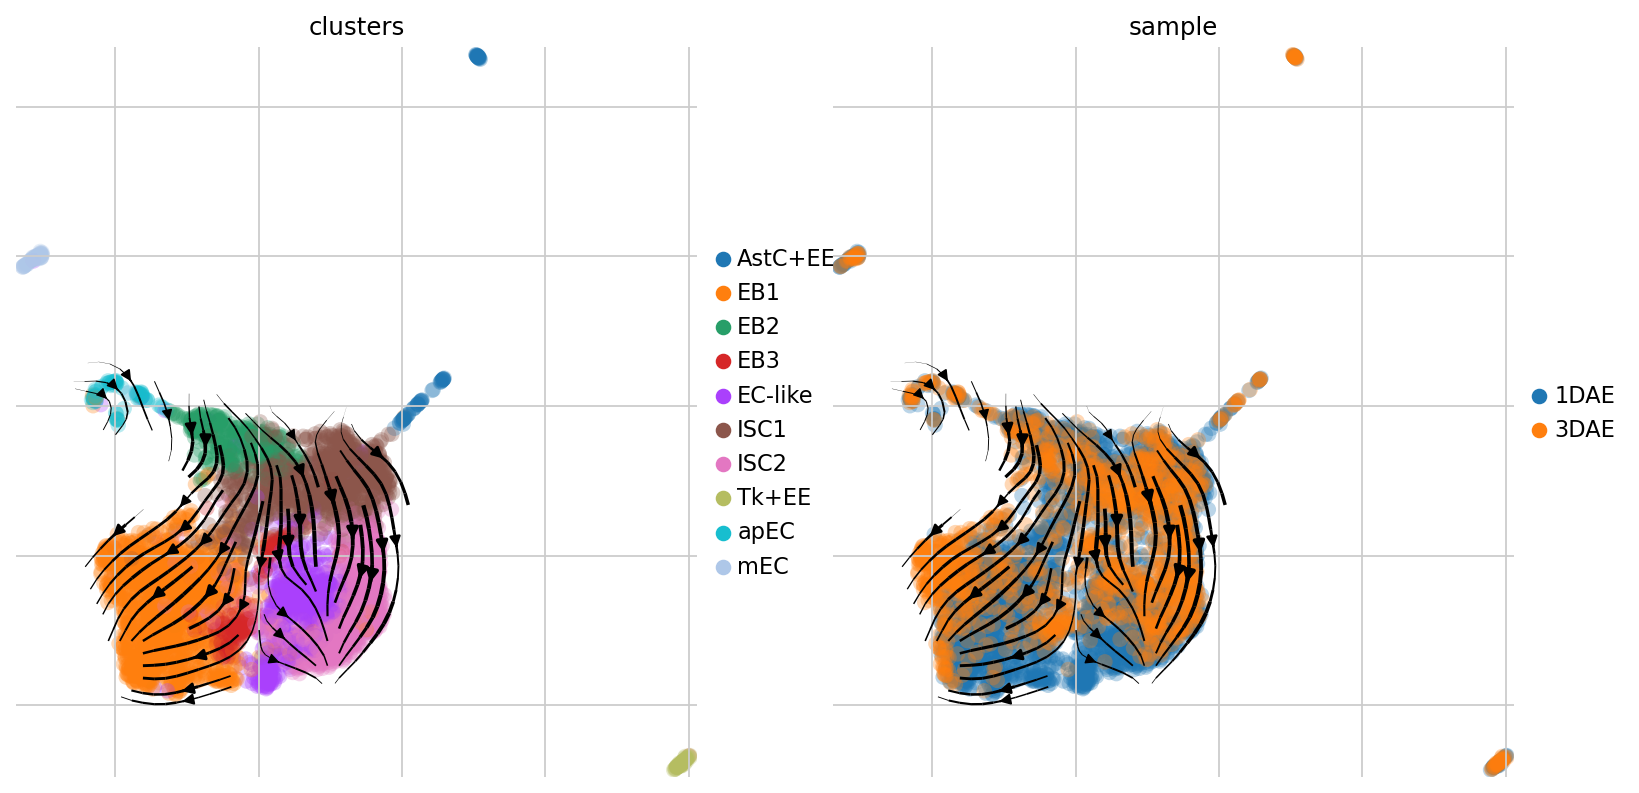

In [36]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = ['clusters', 'sample'], 
                                 frameon = False, save = 'UMAP_stream_sample.pdf', legend_loc = 'right margin')

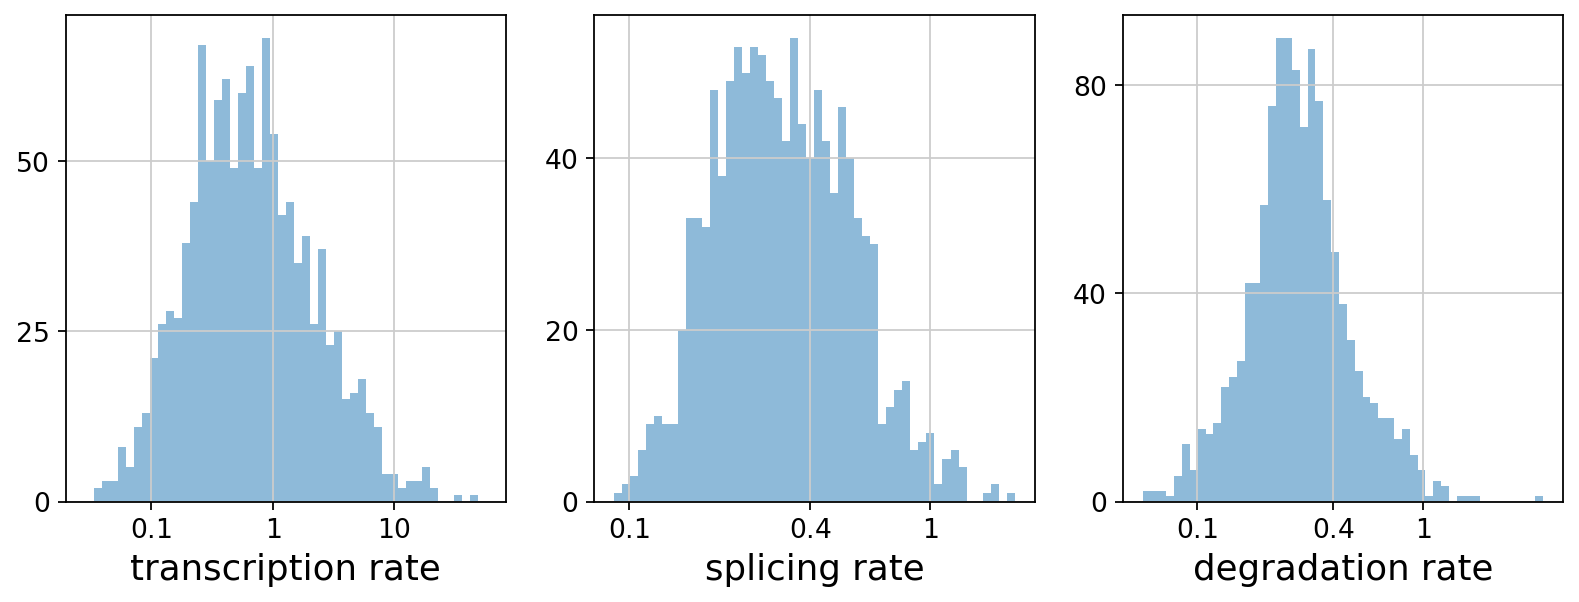

fit
AACCATGGTAAGCAAT  0.0
AACCCAAAGCTATCTG  0.0
AAAGGATTCTTGTGCC  0.0
AACAAAGAGAATAGTC  0.0
AACAAGACAGCTTCGG  0.0

In [37]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

In [38]:
adata.obs

orig.ident  nCount_spliced  nFeature_spliced  \
AACCATGGTAAGCAAT  SeuratProject         42819.0              3477   
AACCCAAAGCTATCTG  SeuratProject         27407.0              3018   
AAAGGATTCTTGTGCC  SeuratProject         22334.0              2928   
AACAAAGAGAATAGTC  SeuratProject         14780.0              1958   
AACAAGACAGCTTCGG  SeuratProject         22777.0              2480   
...                         ...             ...               ...   
TTTGGTTGTACGGATG  SeuratProject         75180.0              4451   
TTGGTTTAGGCATCAG  SeuratProject         22748.0              2405   
TTGGTTTAGACCATGG  SeuratProject         11717.0              1617   
TTTCCTCTCGGTAGGA  SeuratProject         70083.0              4151   
TTGTGTTCAGCGGTCT  SeuratProject         48166.0              3397   

                  nCount_unspliced  nFeature_unspliced  nCount_ambiguous  \
AACCATGGTAAGCAAT            3926.0                 714            1101.0   
AACCCAAAGCTATCTG            2207.0                 517             657.0   
AAAGGATTCTTGTGCC            1371.0                 397             567.0   
AACAAAGAGAATAGTC            1265.0                 277             356.0   
AACAAGACAGCTTCGG            1275.0                 352             451.0   
...                            ...                 ...               ...   
TTTGGTTGTACGGATG            4484.0                 772            1434.0   
TTGGTTTAGGCATCAG            3086.0                 520             670.0   
TTGGTTTAGACCATGG            1809.0                 344             429.0   
TTTCCTCTCGGTAGGA            3401.0                 780            1640.0   
TTGTGTTCAGCGGTCT            4553.0                 812            1397.0   

                  nFeature_ambiguous sample  percent.mt  percent.rb  ...  \
AACCATGGTAAGCAAT                 318   1DAE    4.821462   53.670100  ...   
AACCCAAAGCTATCTG                 240   1DAE    1.833643   57.094903  ...   
AAAGGATTCTTGTGCC                 211   1DAE    1.027587   45.750873  ...   
AACAAAGAGAATAGTC                 148   1DAE    2.239615   59.397835  ...   
AACAAGACAGCTTCGG                 171   1DAE    2.767063   57.623919  ...   
...                              ...    ...         ...         ...  ...   
TTTGGTTGTACGGATG                 341   3DAE    2.585536   55.300612  ...   
TTGGTTTAGGCATCAG                 244   3DAE    3.781349   57.969931  ...   
TTGGTTTAGACCATGG                 164   3DAE    4.612653   58.880259  ...   
TTTCCTCTCGGTAGGA                 344   3DAE    2.169893   46.502005  ...   
TTGTGTTCAGCGGTCT                 361   3DAE    4.248415   59.228501  ...   

                    ident  sample_batch Clusters         _X         _Y  \
AACCATGGTAAGCAAT      EB1   1DAE_1DAE:x        3 -30.738956  -6.097093   
AACCCAAAGCTATCTG     ISC1   1DAE_1DAE:x        2 -30.671553   3.403684   
AAAGGATTCTTGTGCC     ISC1   1DAE_1DAE:x        1  22.289242  25.160275   
AACAAAGAGAATAGTC     ISC2   1DAE_1DAE:x        1  28.603315  29.788687   
AACAAGACAGCTTCGG  EC-like   1DAE_1DAE:x        2 -33.416283  -2.823817   
...                   ...           ...      ...        ...        ...   
TTTGGTTGTACGGATG     ISC1   3DAE_3DAE:x        2  12.363239  15.870676   
TTGGTTTAGGCATCAG      EB1   3DAE_3DAE:x        0   3.402410 -26.382795   
TTGGTTTAGACCATGG     ISC2   3DAE_3DAE:x        6 -25.613077 -23.086945   
TTTCCTCTCGGTAGGA     ISC1   3DAE_3DAE:x        1 -19.884691  -2.706260   
TTGTGTTCAGCGGTCT     ISC2   3DAE_3DAE:x        0 -19.123198 -28.278101   

                 initial_size_spliced initial_size_unspliced initial_size  \
AACCATGGTAAGCAAT                42819                   3926      42819.0   
AACCCAAAGCTATCTG                27407                   2207      27407.0   
AAAGGATTCTTGTGCC                22334                   1371      22334.0   
AACAAAGAGAATAGTC                14780                   1265      14780.0   
AACAAGACAGCTTCGG                22777                   1275      22777.0   
...            

# Run CellRank
Reference<br>
https://cellrank.readthedocs.io/en/stable/cellrank_basics.html#Import-packages-&-data

### Identify terminal states

In [39]:
cr.tl.terminal_states(adata, cluster_key="clusters", weight_connectivities=0.2)

/tmp/ipykernel_1278616/1878820466.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata, cluster_key="clusters", weight_connectivities=0.2)
/opt/conda/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/4184 [00:00<?, ?cell/s]

  0%|          | 0/4184 [00:00<?, ?cell/s]

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000078e+00 -1.8724071889147675e-03 
0.0000000000000000e+00 9.8501794696547140e-01 


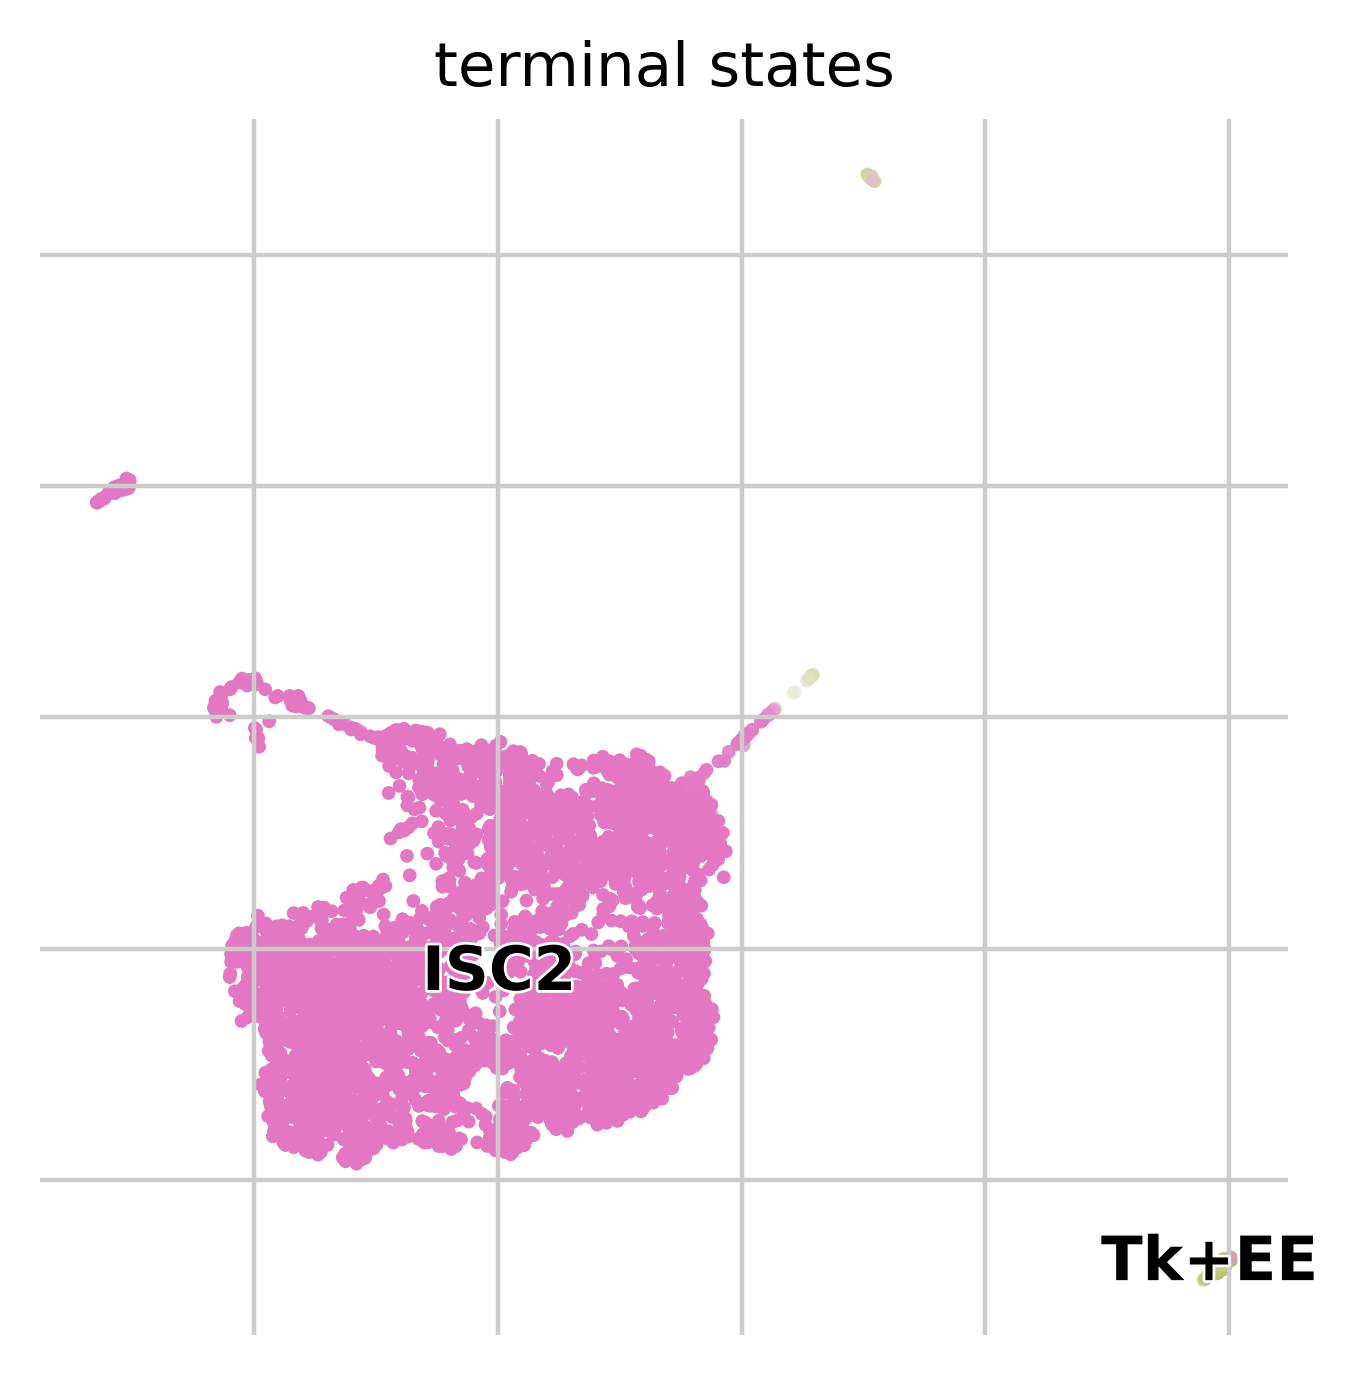

In [40]:
cr.pl.terminal_states(adata)

### Identify initial states

/tmp/ipykernel_1278616/1187097337.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata, cluster_key="clusters")
/opt/conda/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/4184 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4184 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999678e-01 -4.6507272822255939e-02 -2.6444681754727393e-02 1.4533489202530417e-01 
0.0000000000000000e+00 9.9179166953910780e-01 -6.7260122293397442e-03 2.4315482233863314e-02 
0.0000000000000000e+00 0.0000000000000000e+00 9.6298661490625737e-01 -1.5346507610923684e-02 
0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 9.5825878133542242e-01 


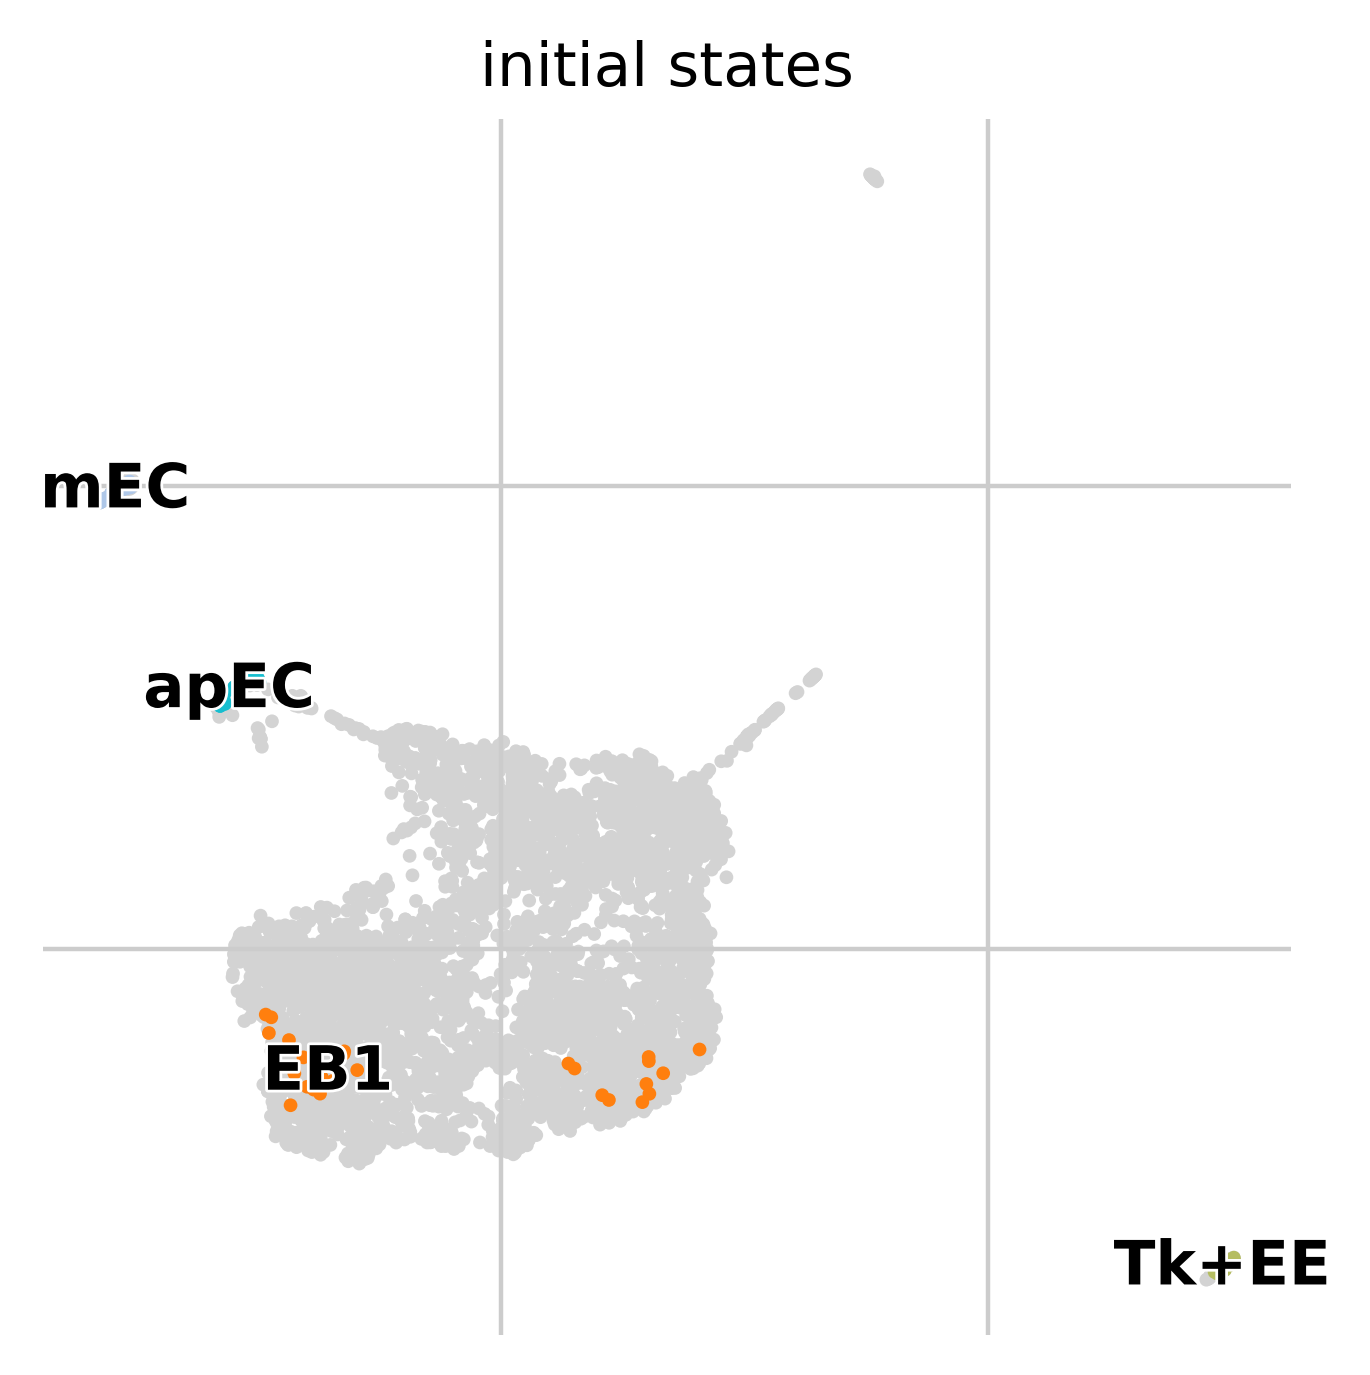

In [41]:
cr.tl.initial_states(adata, cluster_key="clusters")
cr.pl.initial_states(adata, discrete=True)

### Compute fate maps

/tmp/ipykernel_1278616/1878844763.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)


  0%|          | 0/2 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


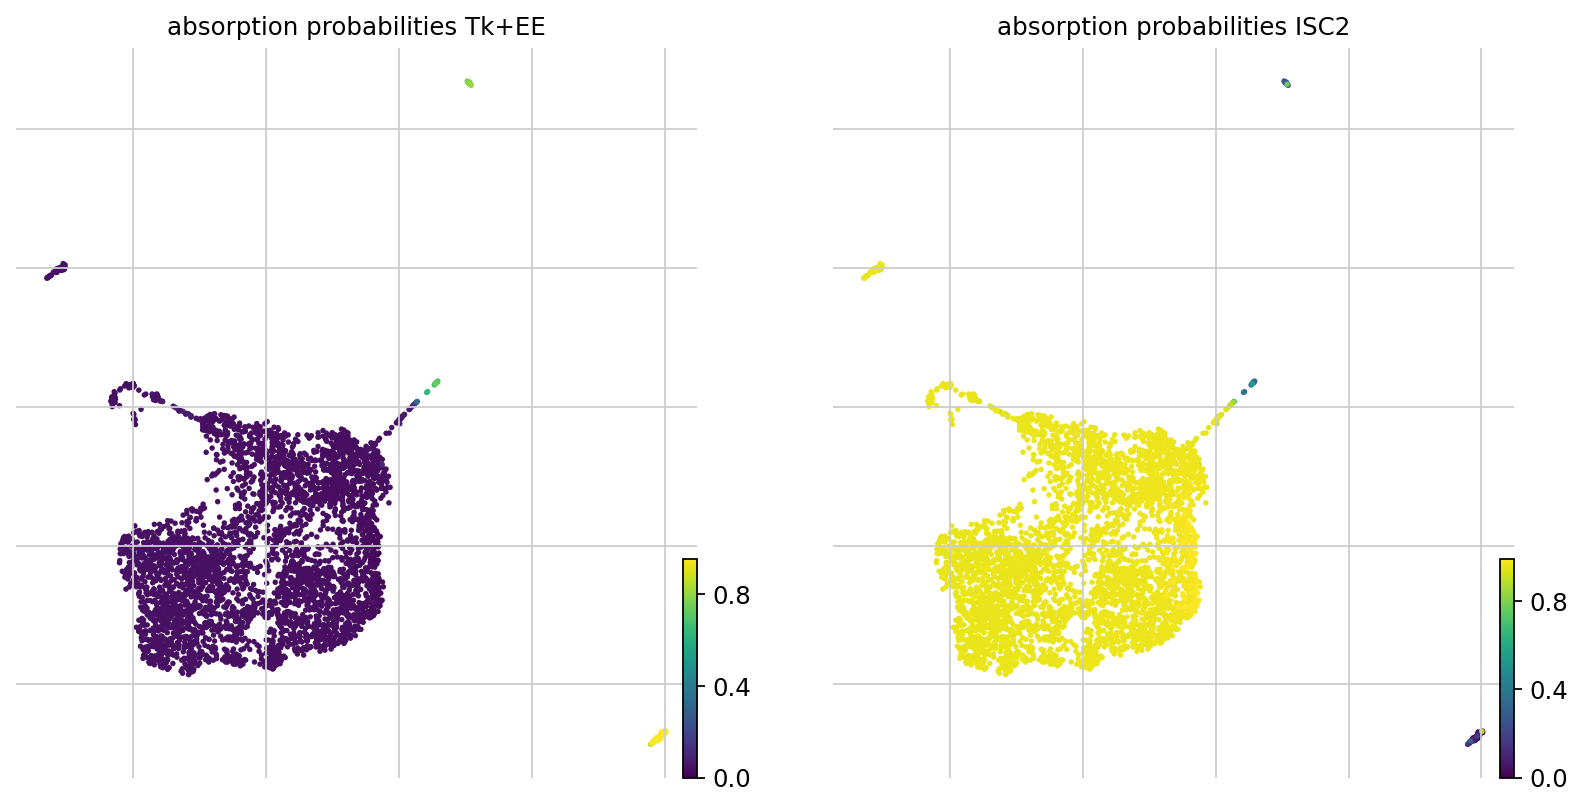

In [42]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False)

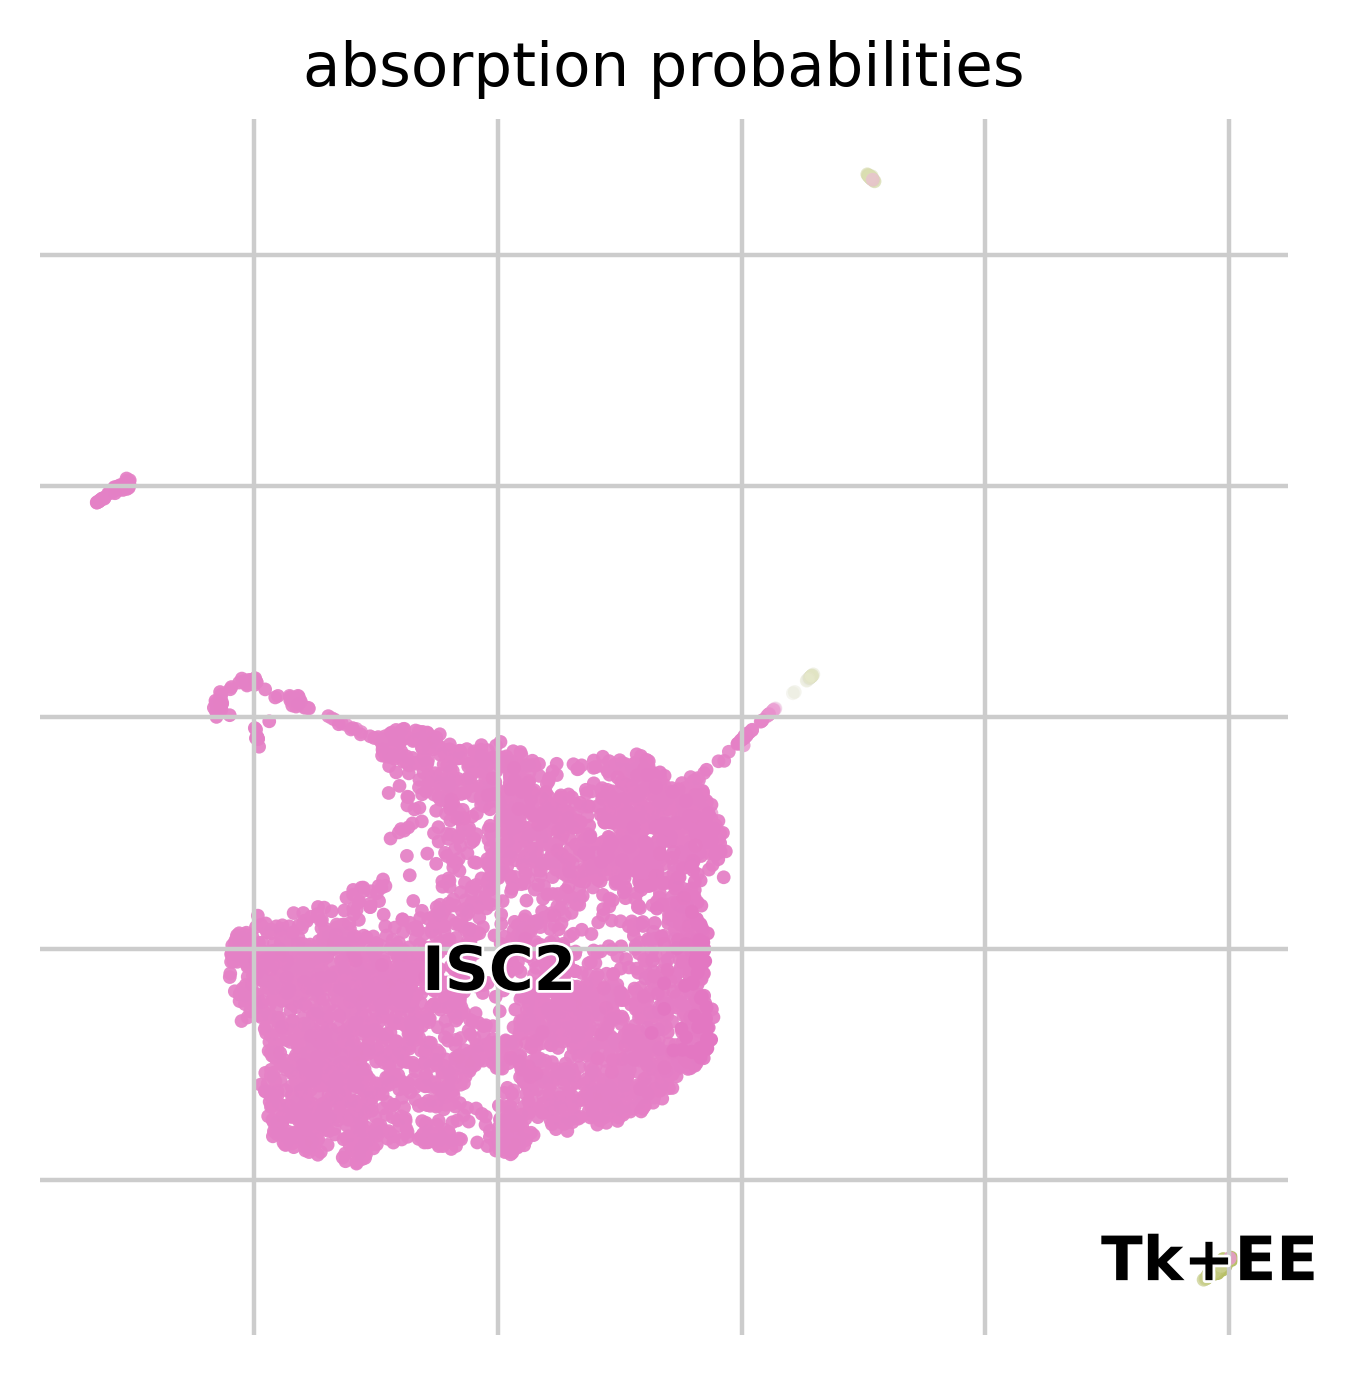

In [43]:
cr.pl.lineages(adata, same_plot=True)

### Directed PAGA

In [44]:
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:07) --> added 
    'latent_time', shared time (adata.obs)


In [45]:
scv.tl.paga(
    adata,
    groups="clusters",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
)

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/opt/conda/lib/python3.9/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


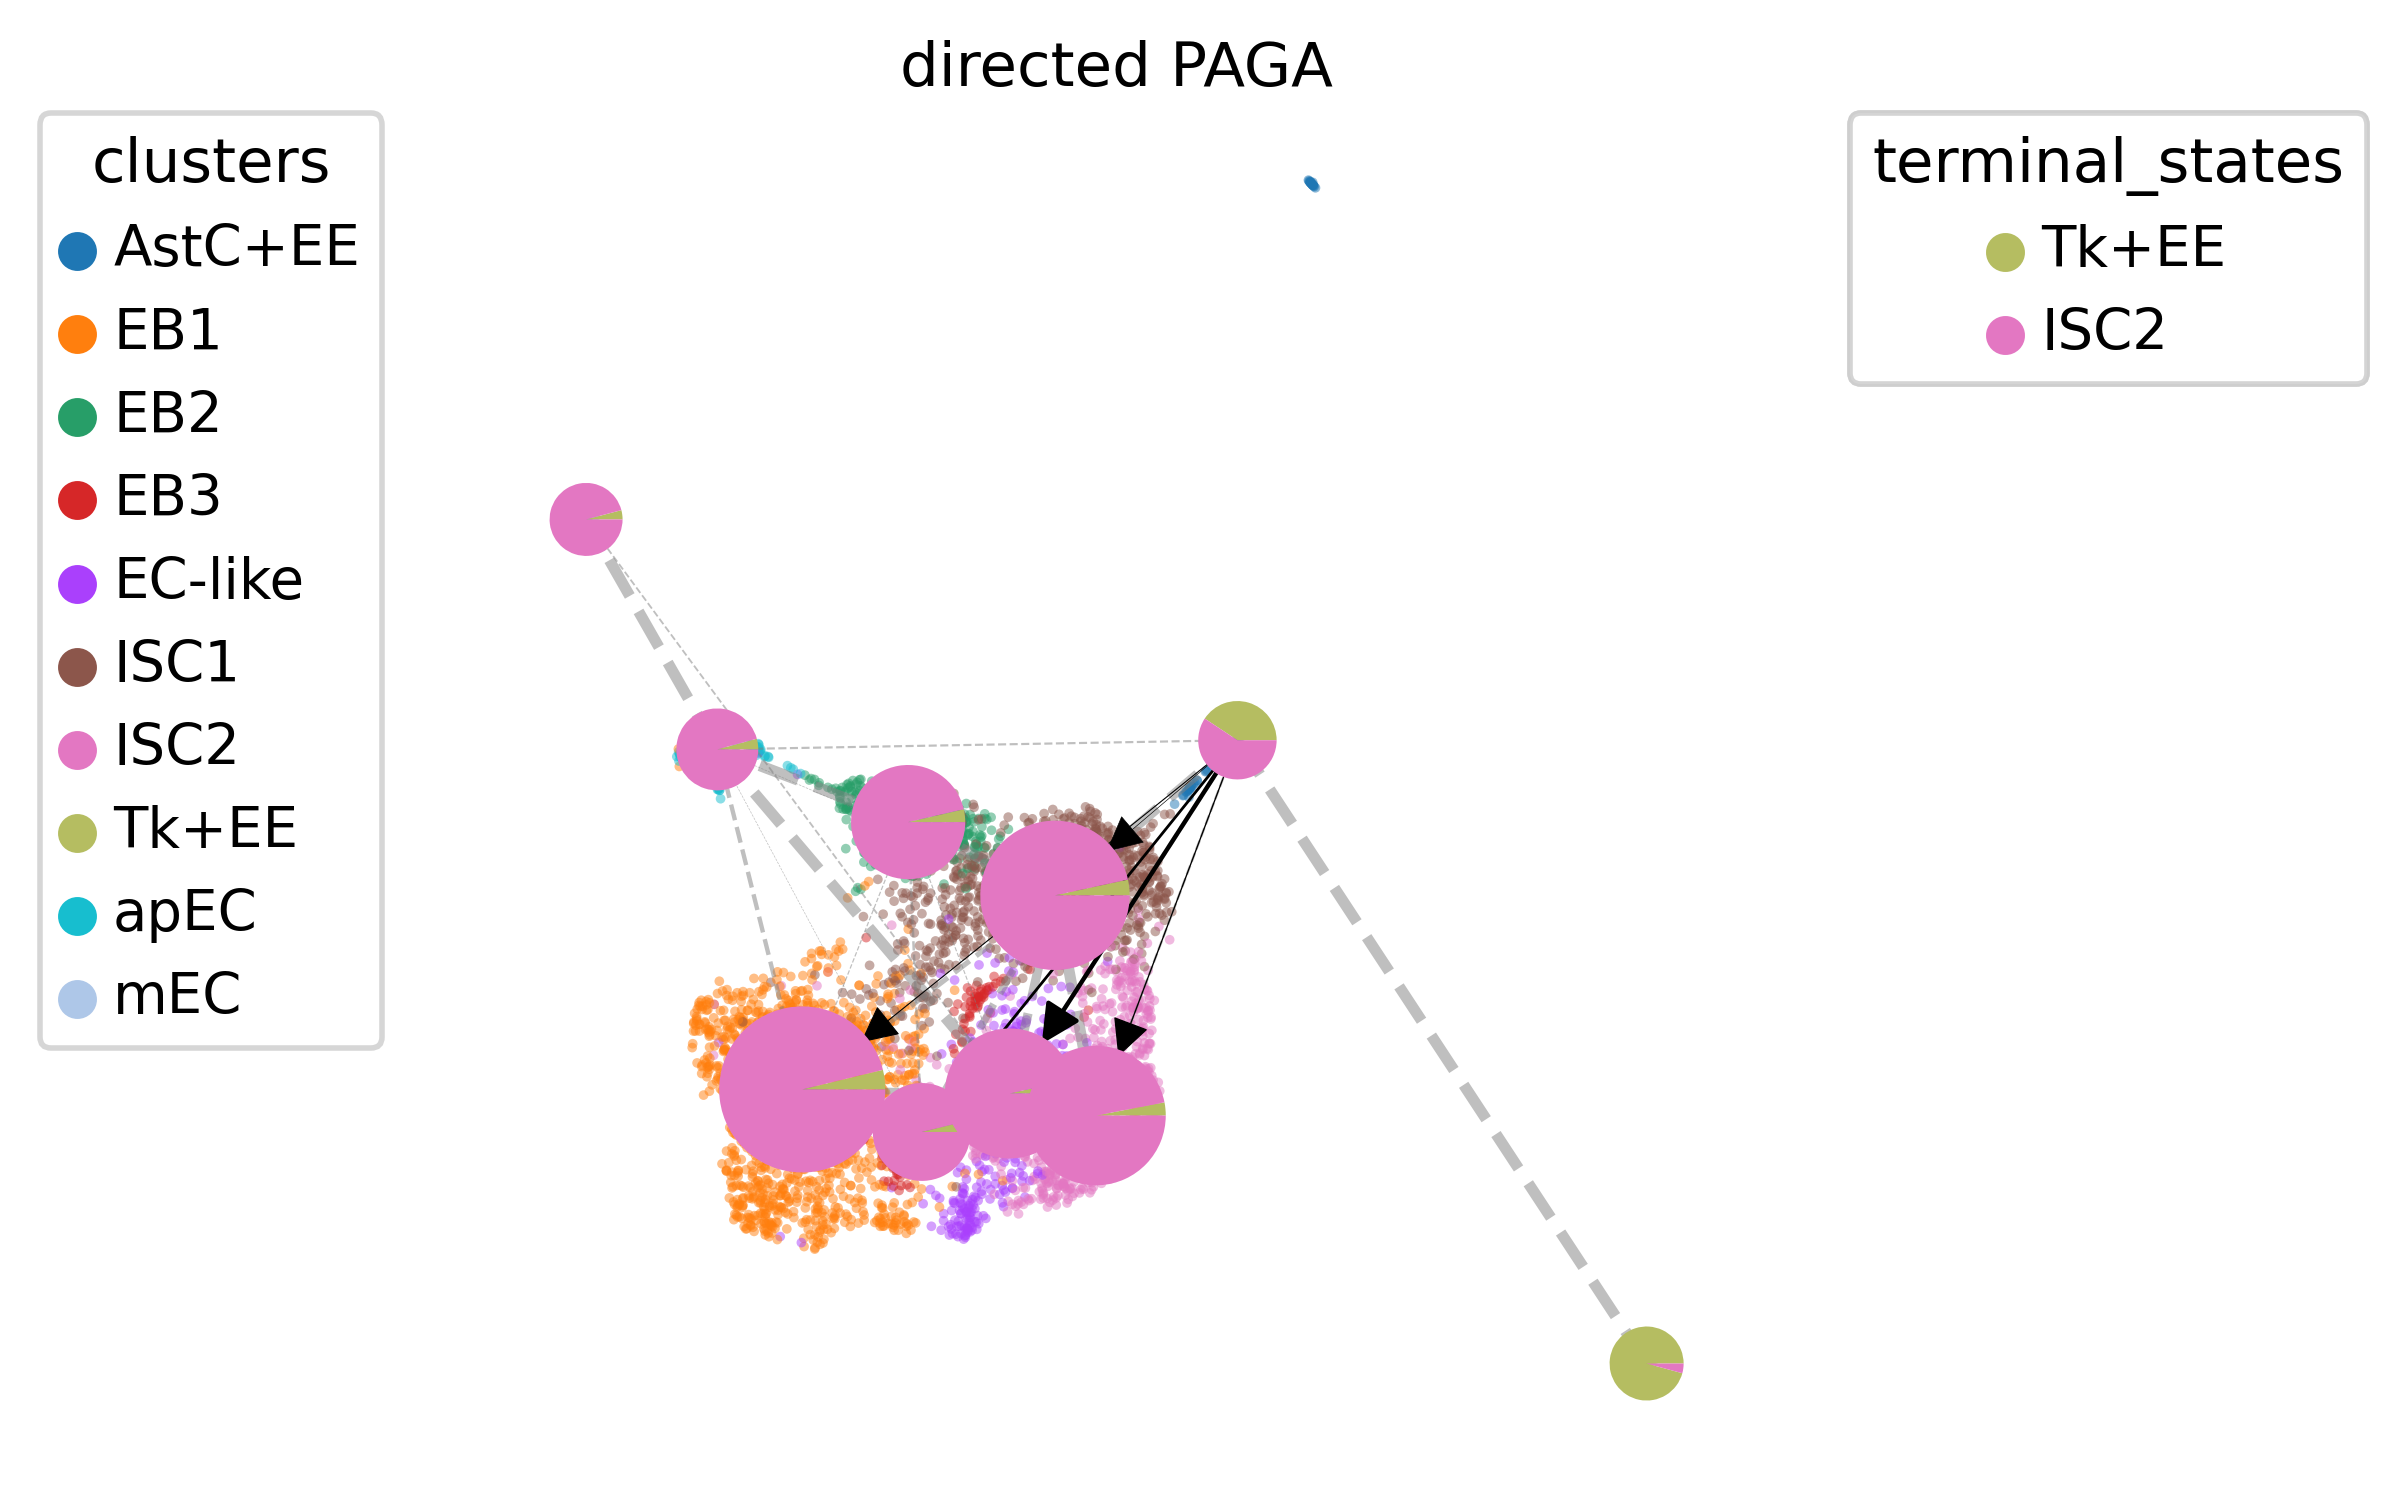

In [46]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="clusters",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=2,
    edge_width_scale=1,
    max_edge_width=2,
    title="directed PAGA",
)

### Compute lineage drivers

In [47]:
cr.tl.lineage_drivers(adata)


/tmp/ipykernel_1278616/775505281.py:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata)


Tk+EE_corr  Tk+EE_pval  Tk+EE_qval  Tk+EE_ci_low  Tk+EE_ci_high  \
7B2        0.876212    0.000000    0.000000      0.868982       0.883068   
Pal2       0.846710    0.000000    0.000000      0.837906       0.855074   
CG13086    0.816974    0.000000    0.000000      0.806641       0.826808   
CG6218     0.792256    0.000000    0.000000      0.780696       0.803274   
Phm        0.789785    0.000000    0.000000      0.778104       0.800919   
...             ...         ...         ...           ...            ...   
CG4860    -0.061082    0.000077    0.000157     -0.091215      -0.030837   
shf       -0.061861    0.000062    0.000128     -0.091991      -0.031618   
Adgf-A    -0.063601    0.000038    0.000080     -0.093722      -0.033363   
Jabba     -0.068523    0.000009    0.000020     -0.098621      -0.038301   
bib       -0.070415    0.000005    0.000011     -0.100503      -0.040199   

         ISC2_corr  ISC2_pval  ISC2_qval  ISC2_ci_low  ISC2_ci_high  
7B2      -0.876212   0.000000   0.000000    -0.883068     -0.868982  
Pal2     -0.846710   0.000000   0.000000    -0.855074     -0.837906  
CG13086  -0.816974   0.000000   0.000000    -0.826808     -0.806641  
CG6218   -0.792256   0.000000   0.000000    -0.803274     -0.780696  
Phm      -0.789785   0.000000   0.000000    -0.800919     -0.778104  
...            ...        ...        ...          ...           ...  
CG4860    0.061082   0.000077   0.000157     0.030836      0.091215  
shf       0.061861   0.000062   0.000128     0.031618      0.091991  
Adgf-A    0.063601   0.000038   0.000080     0.033363      0.093722  
Jabba     0.068523   0.000009   0.000020     0.038301      0.098621  
bib       0.070415   0.000005   0.000011     0.040199      0.100503  

[9607 rows x 10 columns]

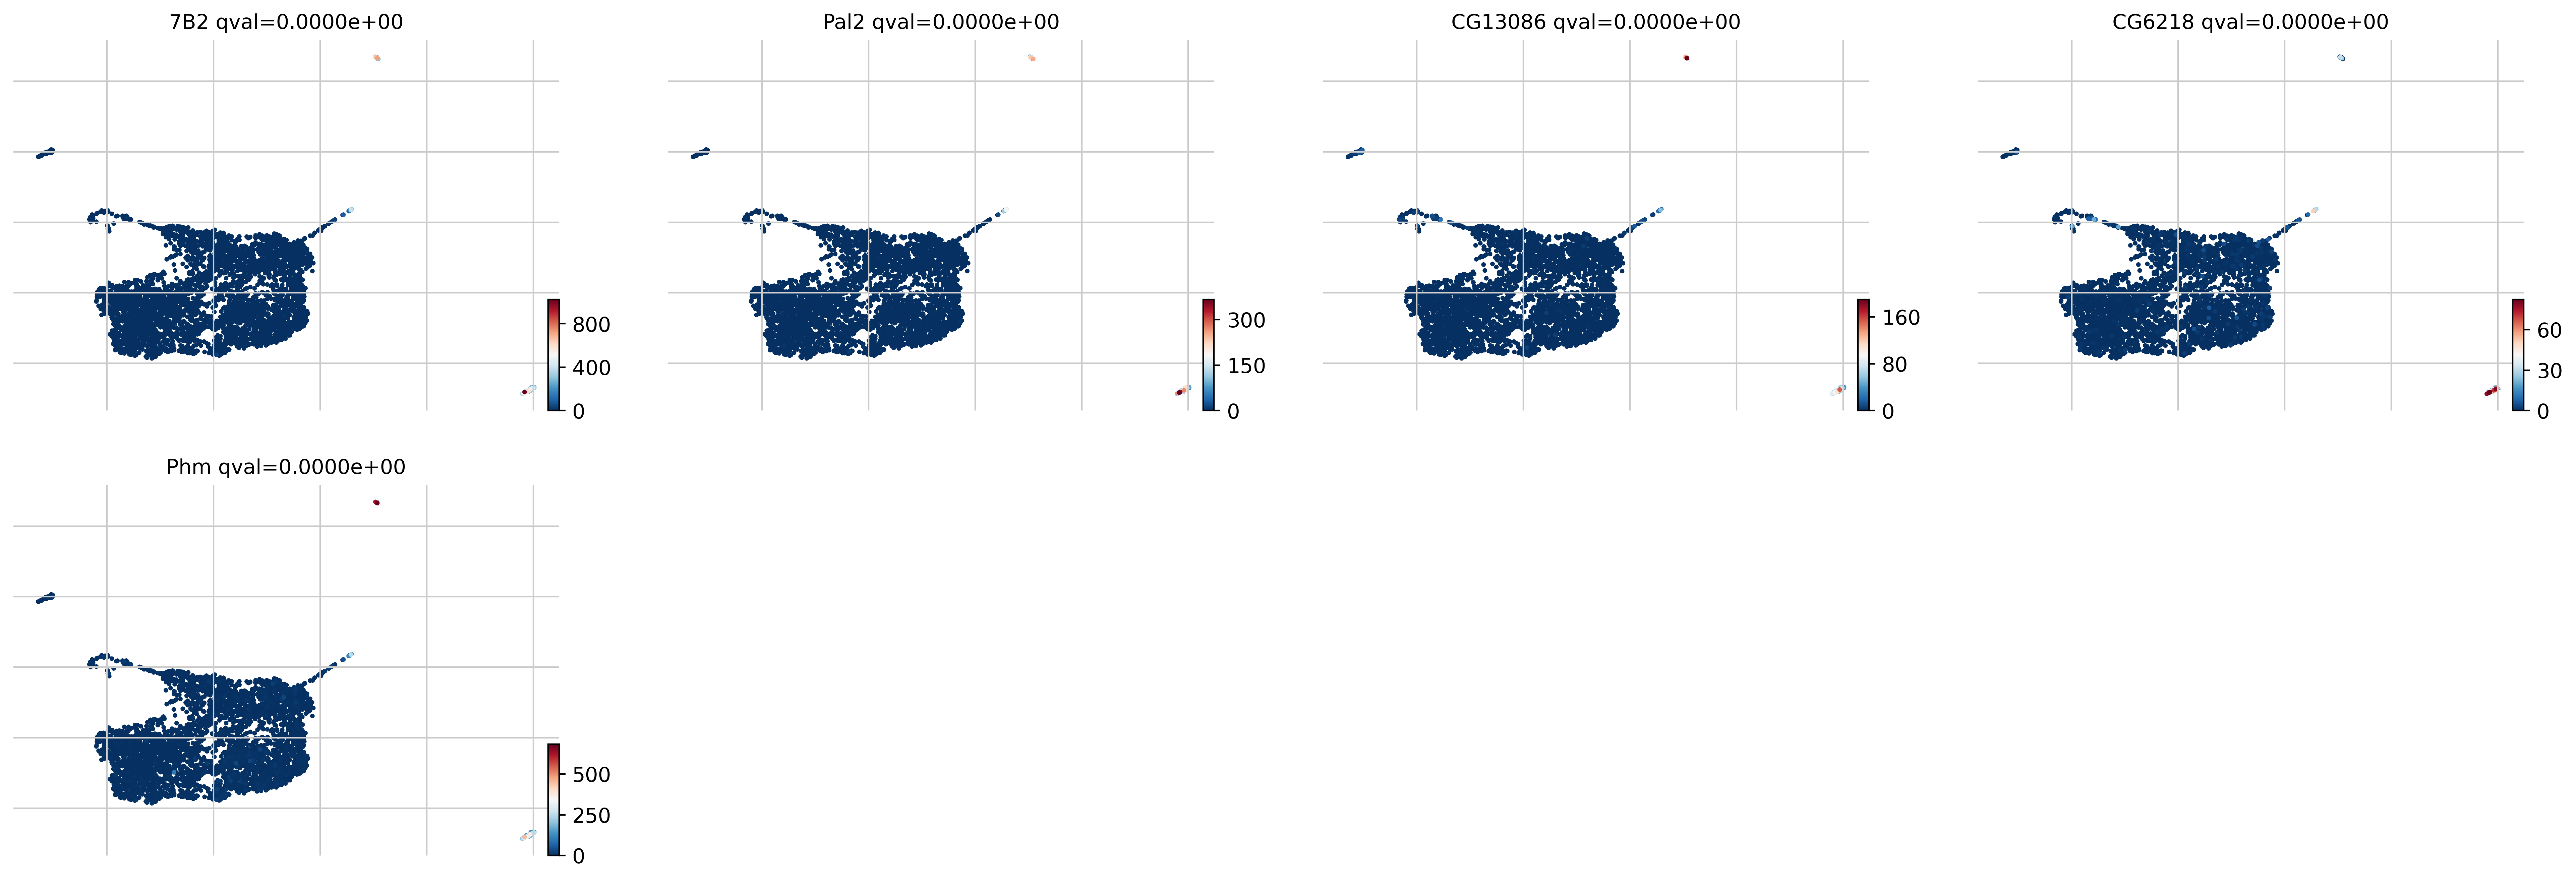

In [48]:
cr.pl.lineage_drivers(adata, lineage="Tk+EE", n_genes=5)

### Gene expression trends

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99318486 0.98678994 0.979011   0.9737577  0.969347
     0.9576859  0.93651277 0.93010527 0.91065943 0.90069586 0.89649844
     0.89097077 0.8868789  0.8759245 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


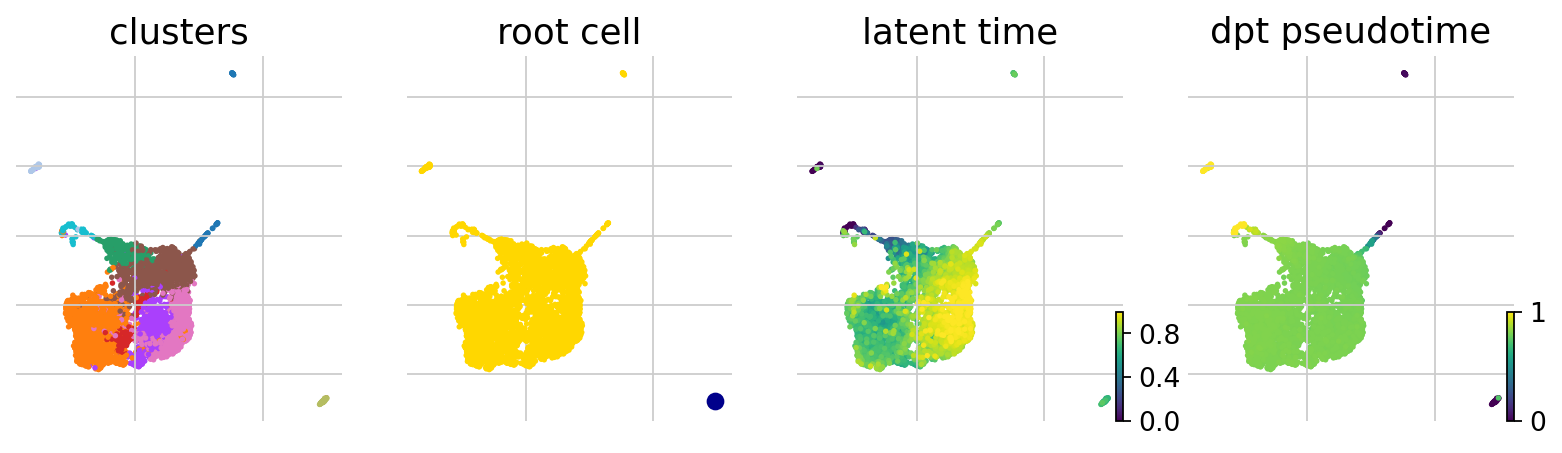

In [49]:
# compue DPT, starting from CellRank defined root cell
root_idx = np.where(adata.obs["initial_states"] == "Tk+EE")[0][0]
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(
    adata,
    color=["clusters", root_idx, "latent_time", "dpt_pseudotime"],
    fontsize=16,
    cmap="viridis",
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    title=["clusters", "root cell", "latent time", "dpt pseudotime"],
)

  0%|          | 0/10 [00:00<?, ?gene/s]

/opt/conda/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/opt/conda/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note li

did not converge


/opt/conda/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/opt/conda/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note li

/opt/conda/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/opt/conda/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note li

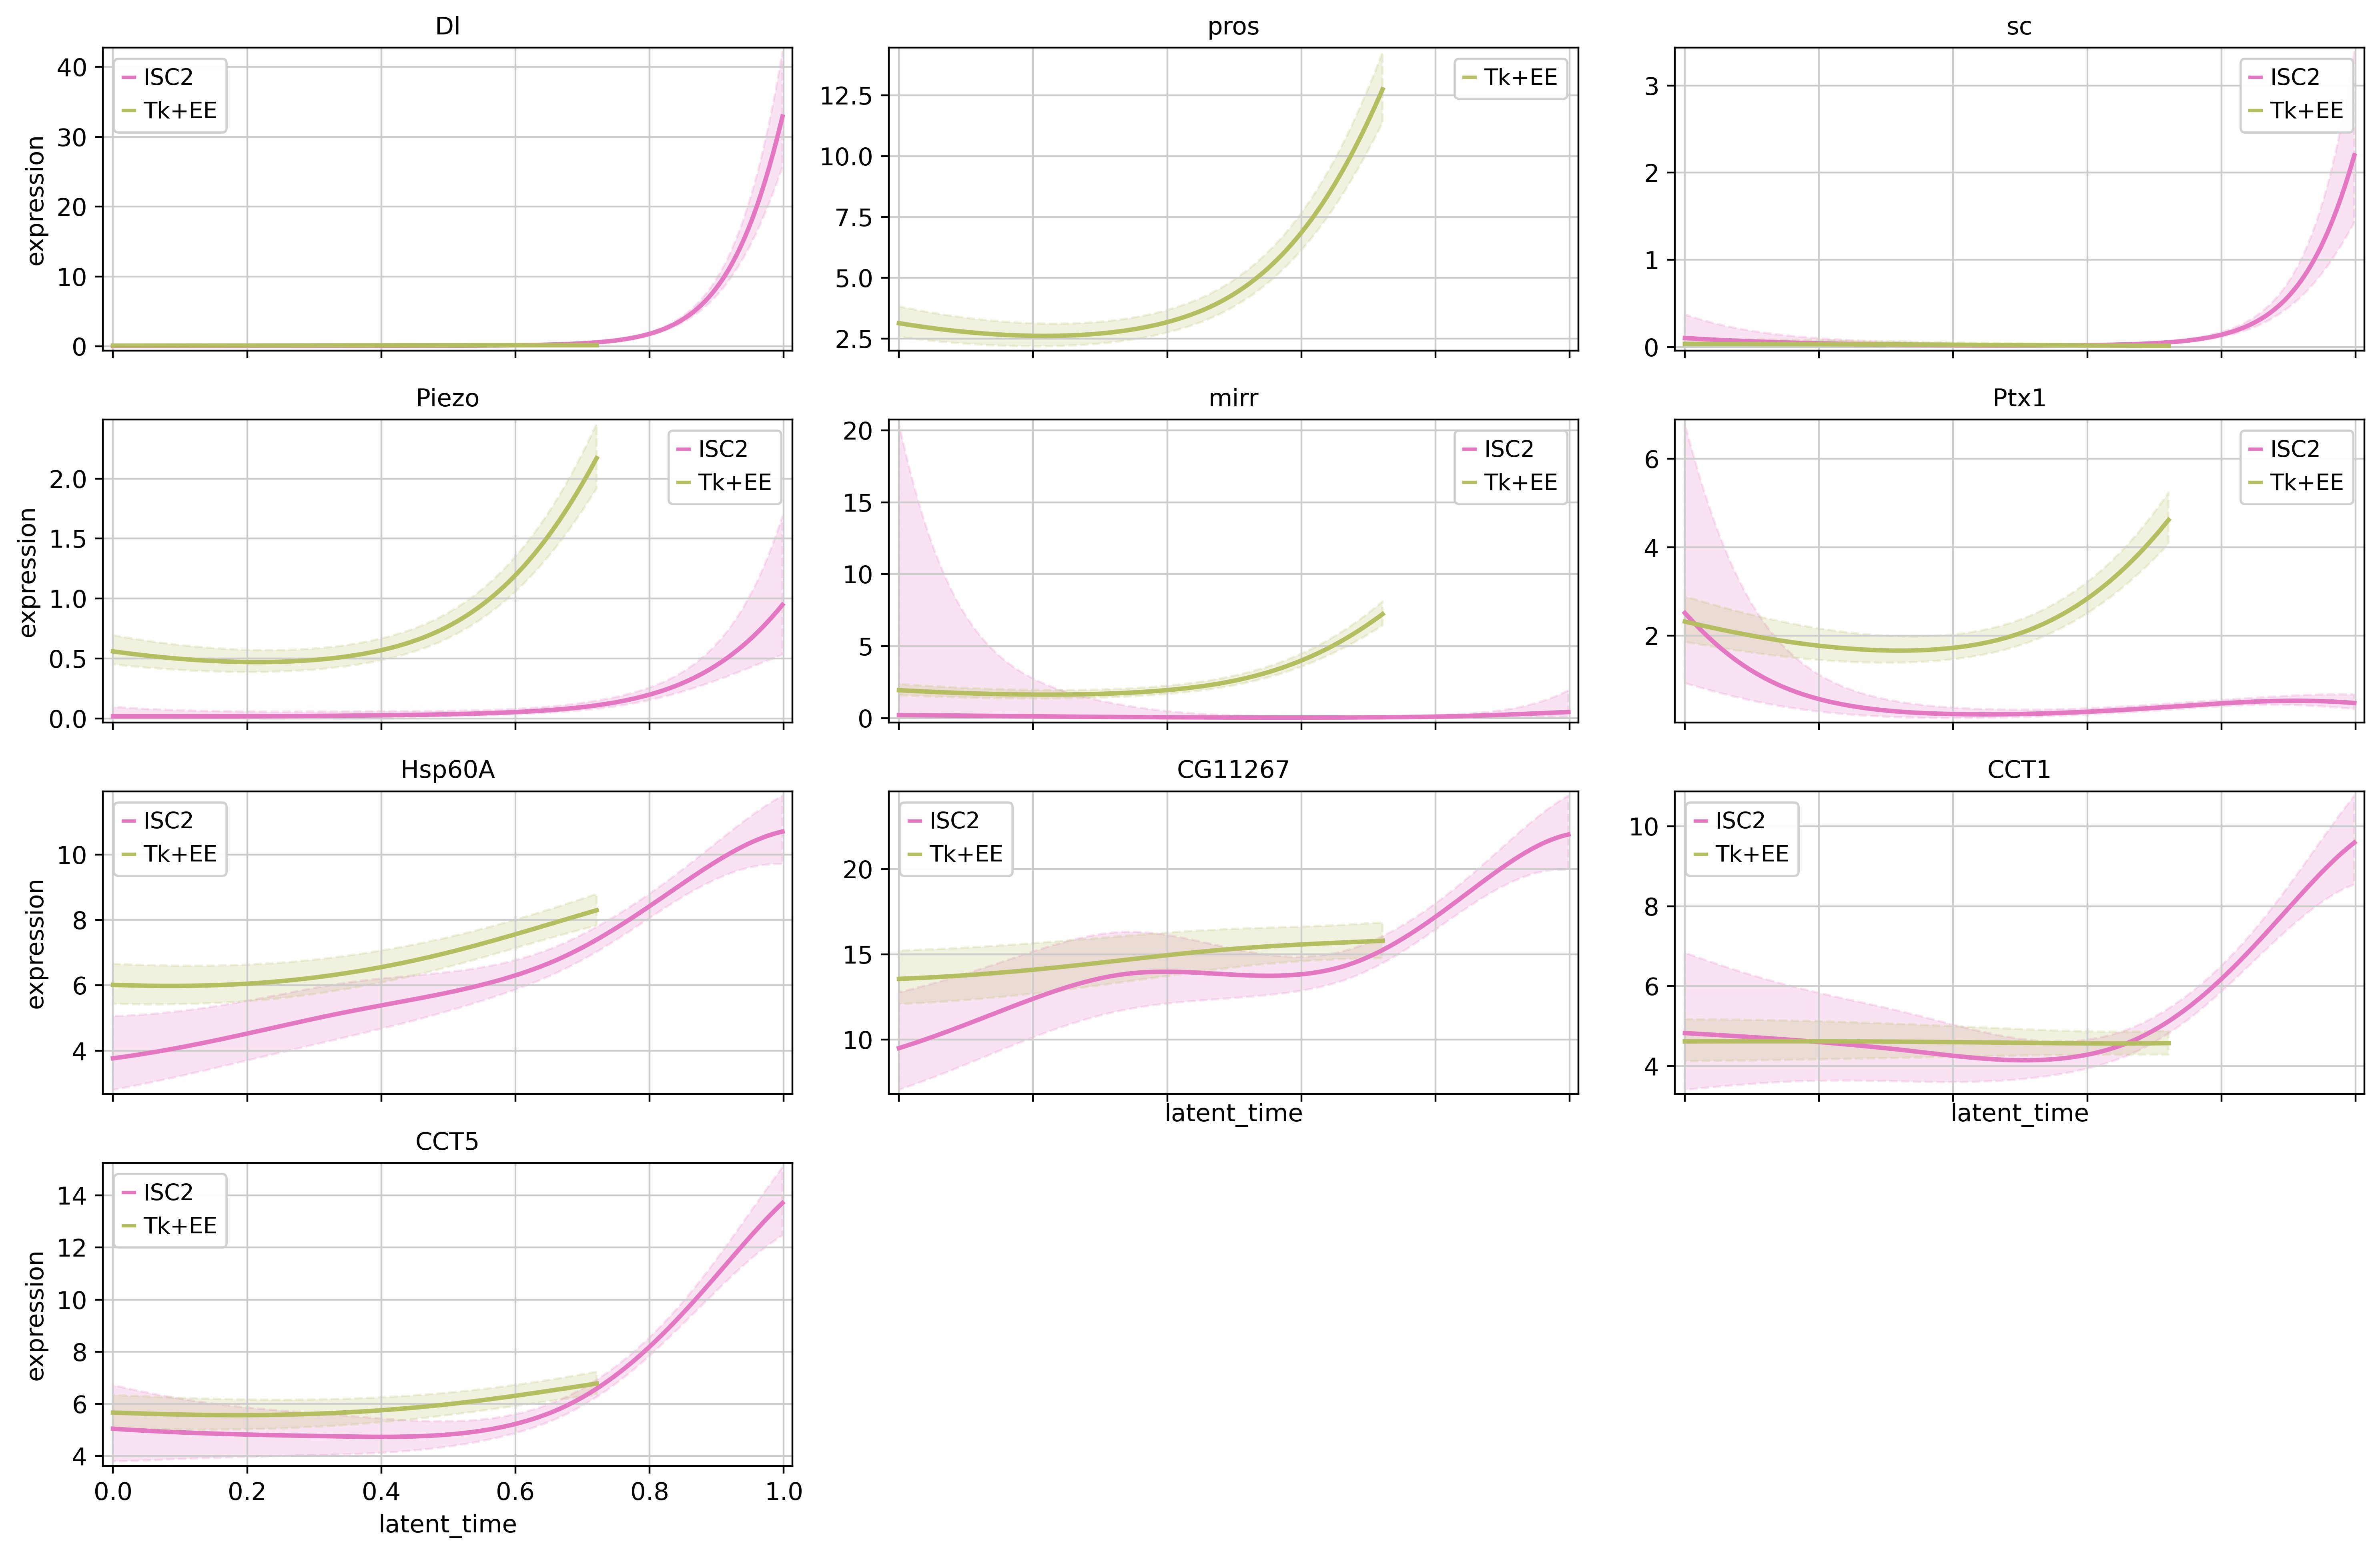

In [52]:
# gene "mira" couldn't be find

model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    genes=["Dl", "pros", "sc", "Piezo", "mirr", "Ptx1", "Hsp60A", "CG11267", "CCT1", "CCT5"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 10),
    n_test_points=200,
    save="gene_trends_2.pdf"
)